In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import spotipy 
import librosa
import librosa.display
import numpy as np
import matplotlib as mpl
import urllib.request
import seaborn as sns
import tqdm
import scipy
import joblib
import os.path
from pathlib import Path
from IPython.display import Audio, Markdown, Image
from spotipy.oauth2 import SpotifyClientCredentials

# Números y Datos
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp1d

# Análisis de sonido
import librosa
import librosa.display
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from sklearn.preprocessing import quantile_transform

# Styles
sns.set_context('poster')
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [2]:
# Extraemos los dataframes de nuestros files
df_tracks = pd.read_pickle('../sources/tracks.pickle')
df_af = pd.read_pickle('../sources/audio_features.pickle')
df_aa = pd.read_pickle('../sources/audio_analysis.pickle') \
    .set_index(['id','start']) \
    .sort_values(by=['id', 'start'], ascending=True, na_position='first')

In [3]:
# Generamos un dataframe combinando la data de tracks y de audio features
df_merged = df_tracks.merge(
    df_af, 
    on='id', 
    how='left'
)
df_merged = df_merged.drop(
    [
     'type_x',
     'type_y',
     'uri_x',
     'uri_y',
     'track_href',
     'analysis_url',
     'href',
     'preview_url',
     'external_ids',
     'duration_ms_y'
    ], 
    1
)

df_merged.rename(columns = {"duration_ms_x": "duration_ms"}, inplace = True)

In [4]:
# Extraemos para cada registro la variable release_date y la asignamos a una nueva columna en nuestro dataframe.

# Función que generamos para formatear la fecha
def date_formator(date):
    if '-' in date:
        year = pd.to_datetime(date, format = '%Y-%m-%d').year
        return int(year)
    elif int(date)>0:
        year = pd.to_datetime(date, format = '%Y').year
        return int(year)
    return None


df_merged['release_date'] = df_merged['album'].map(lambda x: x['release_date'])
df_merged['release_date'] = df_merged['release_date'].apply(date_formator)
df_merged['release_date'].head()

id
4d3XHYFFuYYzxWr2cJ6yQl    1991.0
3X3p3u03P8eFL8WTH0oaaU    1958.0
4KlXeaheot0OI9PoOWspvZ    2014.0
3j76McoUI18gDoqxYE14Bu    2014.0
4zxd4tiXPlWMqoJltbVTbE    1959.0
Name: release_date, dtype: float64

In [5]:
# Obtengo ids de album
df_merged['album_id'] = df_merged['album'].map(lambda x: x['id'])

# Agrego artistas y género
df_merged[["artists","genre"]] =  df_merged.loc[:,["artists","genre"]] 

In [6]:
# Vemos cuales son nuestras columnas
df_merged.columns.values

array(['album', 'artists', 'available_markets', 'disc_number',
       'duration_ms', 'explicit', 'external_urls', 'is_local', 'name',
       'popularity', 'track_number', 'genre', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'release_date', 'album_id'], dtype=object)

In [7]:
df_merged.sample(3).T

id,3xEJsNuVvU7IdX3VxAik2X,252wJ7a1gTi59YZCDYiKu0,0LqUgqKVbwfC18JWXKEYZM
album,"{'album_type': 'ALBUM', 'artists': [{'external...","{'album_type': 'ALBUM', 'artists': [{'external...","{'album_type': 'ALBUM', 'artists': [{'external..."
artists,Das Karussell,Anton Bruckner,Reel Big Fish
available_markets,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...","[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...","[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B..."
disc_number,1,1,1
duration_ms,478373,965915,233131
explicit,False,False,False
external_urls,{'spotify': 'https://open.spotify.com/track/3x...,{'spotify': 'https://open.spotify.com/track/25...,{'spotify': 'https://open.spotify.com/track/0L...
is_local,False,False,False
name,Act III - Delphinus Capensis,Symphony No. 8: I. Allegro moderato,Sell Out - Best Of
popularity,21,17,20


In [8]:
def plot_radar_chart_stats(s25,s50,s75,color,ax):
    grupo=s25.name
    labels = s25.index

    angles=np.linspace(0, 2*np.pi, len(s25), endpoint=False)
    angles=np.append(angles,angles[0])
    s25=np.append(s25,s25[0])
    s50=np.append(s50,s50[0])
    s75=np.append(s75,s75[0])

    ax.plot(angles, s50, 'o-', linewidth=1,color=color,markersize=4)
    ax.set_yticklabels([])
    ax.set_thetagrids(angles * 180/np.pi, labels, fontsize=6, color='gray')
    ax.tick_params(pad=-6, direction='out', length=8, color='k', zorder=-1)
    ax.fill_between(angles, s25, s75, alpha=0.2,color=color)
    ax.set_title(grupo, fontsize=12, loc='left')
    ax.grid(True)
    ax.set_ylim(0,1)


In [9]:
# quantil=50 # 50 quantiles
# df_num = df_merged.copy()
# df_num = df_num.select_dtypes(['number']).drop(['disc_number','track_number','release_date','duration_ms','mode','time_signature'],1)

# quantile_transform(
#         df_num, 
#         n_quantiles = 100,
#         output_distribution = 'uniform', 
#         random_state = 0, 
#         copy = False
#         )

In [10]:
# df_merged.select_dtypes(['number']).drop(['disc_number','track_number','release_date','duration_ms'],1).head()
# df_merged['mode'][1:200]

In [11]:
quantil=100 # 50 quantiles
df_num = df_merged.copy()
df_num = df_num.select_dtypes(['number']).drop(['disc_number','track_number','release_date','duration_ms','mode','time_signature'],1)

df_num = pd.DataFrame(
    quantile_transform(
        df_num, 
        n_quantiles = quantil,
        output_distribution = 'uniform', 
        random_state = 0, 
        copy = True
    ), columns=df_num.columns,index=df_num.index
)
df_num['genre']=df_merged['genre']

normalized_stats_25 = df_num.groupby('genre').quantile(.25)
normalized_stats_50 = df_num.groupby('genre').quantile(.5)
normalized_stats_75 = df_num.groupby('genre').quantile(.75)
df_num.head(20)

,popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
id,,,,,,,,,,,,
4d3XHYFFuYYzxWr2cJ6yQl,0.893939,0.565657,0.177010,0.479798,0.178934,0.599327,0.722222,0.738882,0.608081,0.309343,0.377163,jazz
3X3p3u03P8eFL8WTH0oaaU,0.878788,0.809764,0.237374,0.641414,0.249397,0.429777,0.718855,0.550029,0.099621,0.724518,0.266405,jazz
4KlXeaheot0OI9PoOWspvZ,0.494949,0.974455,0.320707,0.813131,0.481627,0.346801,0.581818,0.737808,0.131180,0.670538,0.210512,jazz
3j76McoUI18gDoqxYE14Bu,0.626263,0.890152,0.474747,0.267677,0.247523,0.072727,0.629004,0.635798,0.962848,0.573487,0.433993,jazz
4zxd4tiXPlWMqoJltbVTbE,0.939394,0.560606,0.176049,0.893939,0.362021,0.202020,0.760101,0.195305,0.279040,0.470707,0.169340,jazz
4LInRUJ6XN1TVnoRVAFcdB,0.000000,0.834707,0.187794,0.166667,0.182467,0.419791,0.473737,0.275733,0.696392,0.249158,0.010094,jazz
16QhvfPMBLpo7sFqOqTff3,0.565657,0.488889,0.211308,0.641414,0.401450,0.260929,0.797980,0.644595,0.599327,0.521465,0.449534,jazz
2kF9Ijd7I2Kk2P4bYqUmzG,0.924242,0.867244,0.365152,0.479798,0.329032,0.376263,0.581818,0.192667,0.552189,0.773197,0.799523,jazz
7pKWTcPfT9mg2iAhobFHpS,0.870385,0.699495,0.201168,0.267677,0.331967,0.627525,0.836364,0.821549,0.505051,0.327273,0.312848,jazz


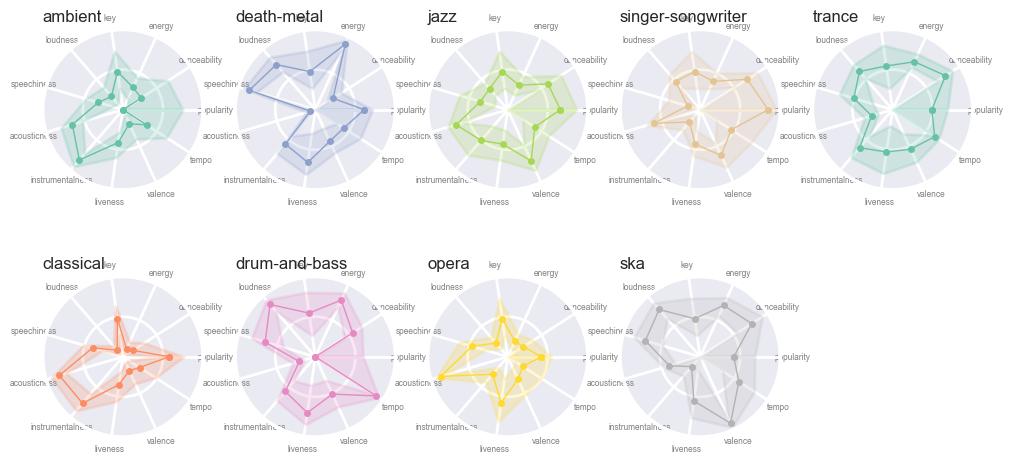

In [12]:
rows=2
my_palette = sns.color_palette("Set2")
q = int(len(normalized_stats_25)/rows)+len(normalized_stats_25)%rows
fig, axs = plt.subplots(rows, q, subplot_kw=dict(polar=True))

for i in range(rows*q):
    if i<len(normalized_stats_25):
        plot_radar_chart_stats(normalized_stats_25.iloc[i],
                               normalized_stats_50.iloc[i],
                               normalized_stats_75.iloc[i],
                               my_palette[i%8],axs[i%rows, int(i/rows)])
    else:
        fig.delaxes(axs[i%rows, int(i/rows)])

plt.savefig('radar_chart.png',dpi=800, bbox_inches = 'tight', pad_inches = 0)
plt.show()

Gráfico Radar de los features por cada género del set de datos.

La línea gruesa indica la mediana, y el sombreado es el rango intercuartil.

Las características se encuentran escaladas y normalizadas por cuantiles (dando una medición robusta de cada feature para hacer las estadísticas comparables)

Análisis de este gráfico
* La ópera y la clásica son los que más acousticness tienen.
* Las canciones de trance son las que en general suelen tener mayor duración (seguidas por las ambient y drum-and-bass).
* La música ambient y classical son las de mayor instrumentalness.
* Death-metal suelen ser el género de mayor liveness junto con drum-and-bass.
* Death-metal es incuestionablemente el género más energético, seguido por drum-and-bass, ska y trance.
* Opera y classical comparten las característica de baja energy, baja valence, bajo tempo, alto acousticness y bajo speechness.
* Los géneros más danceable son singer-songwriter, trance, jazz y ska.
* La variable de popularidad corre a lo largo de todo el espectro para la mayoría de los géneros y ninguno muestra una amplia diferencia con respecto al resto. Más allá de eso, las canciones de singer-songwriter tienen (en media) las canciones más populares, seguidos por jazz y classical.

In [13]:
df_m2 = df_aa

pitches_nombre = ['p00_C','p01_C#','p02_D','p03_D#','p04_E','p05_F',
                 'p06_F#','p07_G','p08_G#','p09_A','p10_A#','p11_B']
df1 = pd.DataFrame(df_m2['pitches'].tolist(), columns=pitches_nombre, index=df_m2.index)
df_m2 = pd.concat([df_m2,df1],axis=1)

timbre_nombre = ['t00','t01','t02','t03','t04','t05',
                 't06','t07','t08','t09','t10','t11']
df1 = pd.DataFrame(df_m2['timbre'].tolist(), columns=timbre_nombre, index=df_m2.index)
df_m2 = pd.concat([df_m2,df1],axis=1).drop(['pitches','timbre'],1)

df1 = None
df_m2.head(3).T

id                00At7PWydsvg7g5xgaYan9                      
start                            0.00000    0.24381    0.41873
duration                         0.24381    0.17492    0.17329
confidence                       0.00000    1.00000    1.00000
loudness_start                 -60.00000  -60.00000  -34.27900
loudness_max_time                0.00000    0.01436    0.01554
loudness_max                   -60.00000  -12.45700  -12.72800
loudness_end                     0.00000    0.00000    0.00000
p00_C                            1.00000    0.12100    0.03200
p01_C#                           1.00000    0.99600    1.00000
p02_D                            1.00000    0.08000    0.06000
p03_D#                           1.00000    0.10400    0.05900
p04_E                            1.00000    1.00000    0.36800
p05_F                            1.00000    0.22300    0.08400
p06_F#                           1.00000    0.04300    0.03600
p07_G                            1.00000    0.04700    0.04100
p08_G#                           1.00000    0.17600    0.10600
p09_A                            1.00000    0.42200    0.38000
p10_A#                           1.00000    0.12900    0.11200
p11_B                            1.00000    0.06200    0.08700
t00                              0.00000   37.64100   38.17100
t01                            171.13000  -77.64300  -17.74100
t02                              9.46900  -30.61300  -22.79800
t03                            -28.48000  137.46200  149.22300
t04                             57.49100   36.96000   31.83300
t05                            -50.06700  -51.02400  -53.44600
t06                             14.83300  -18.74500  -36.48500
t07                              5.35900  -28.82200  -39.47900
t08                            -27.22800   -7.17000  -25.79500
t09                              0.97300   -1.99400   -1.90300
t10                            -10.64000  -15.69500  -21.90800
t11                             -7.22800    9.41100   15.93400

In [50]:
medias = df_m2.groupby(level='id').mean().drop(['duration'],1)#.iloc[:,7:]

In [51]:
medias.head(3).T

id,00At7PWydsvg7g5xgaYan9,00BgcUYkIImsDN5rNjkR1U,00WgnFIsY1y84p7mYAJRuF
confidence,0.523191,0.470216,0.452725
loudness_start,-9.056660,-9.788445,-17.176795
loudness_max_time,0.042637,0.033210,0.033198
loudness_max,-2.085701,-3.185968,-9.595632
loudness_end,-0.067340,-0.052149,-0.040650
p00_C,0.372569,0.255472,0.523316
p01_C#,0.746600,0.541902,0.378992
p02_D,0.288627,0.147708,0.397866
p03_D#,0.284531,0.166854,0.515072
p04_E,0.279819,0.286158,0.347002


In [52]:
desvios = df_m2.groupby(level='id').std().drop(['duration'],1)#.iloc[:,7:]

In [53]:
desvios.head(3).T

id,00At7PWydsvg7g5xgaYan9,00BgcUYkIImsDN5rNjkR1U,00WgnFIsY1y84p7mYAJRuF
confidence,0.253678,0.287486,0.287122
loudness_start,6.145573,6.821286,8.734792
loudness_max_time,0.036067,0.045866,0.045160
loudness_max,3.539792,4.992566,8.701703
loudness_end,2.010076,1.643316,1.561738
p00_C,0.279113,0.236511,0.332836
p01_C#,0.315281,0.360120,0.302142
p02_D,0.226995,0.157930,0.318847
p03_D#,0.253614,0.196982,0.353850
p04_E,0.270029,0.316042,0.295190


In [54]:
df_pitches_timbres_medias_desvios = pd.merge(medias, desvios, on='id', suffixes=('_medias', '_desvios'))

In [55]:
quantil=100 # 50 quantiles

features_2 = df_pitches_timbres_medias_desvios.columns
df_pitches_timbres_medias_desvios_normalizado_quantiles = pd.DataFrame(
    quantile_transform(
        df_pitches_timbres_medias_desvios[features_2], 
        n_quantiles = quantil,
        output_distribution = 'normal', 
        random_state = 0, 
        copy = True
    ), columns=features_2,index=medias.index
)

df_pitches_timbres_medias_desvios_normalizado_quantiles.head(3).T

id,00At7PWydsvg7g5xgaYan9,00BgcUYkIImsDN5rNjkR1U,00WgnFIsY1y84p7mYAJRuF
confidence_medias,0.261043,-0.073415,-0.182676
loudness_start_medias,1.708720,1.457230,0.216779
loudness_max_time_medias,-1.027028,-1.563270,-1.564166
loudness_max_medias,2.145671,1.680142,0.136648
loudness_end_medias,-0.094938,0.355166,0.735418
p00_C_medias,-0.416135,-1.177655,0.516576
p01_C#_medias,1.958547,0.589622,-0.285621
p02_D_medias,-0.400919,-1.680308,0.446269
p03_D#_medias,-0.094078,-1.205499,1.751907
p04_E_medias,-0.437952,-0.376290,0.118683


In [56]:
df_merged2 = df_merged.select_dtypes(['number']).drop(['disc_number','track_number','release_date'],1)

df_merged_quantiles = pd.DataFrame(
    quantile_transform(
        df_merged2,
        n_quantiles = quantil,
        output_distribution = 'normal', 
        random_state = 0, 
        copy = True
    ), columns=df_merged2.columns,index=df_merged2.index
)
df_merged_quantiles['genre']=df_merged['genre']

df_merged_quantiles.head(3).T

id,4d3XHYFFuYYzxWr2cJ6yQl,3X3p3u03P8eFL8WTH0oaaU,4KlXeaheot0OI9PoOWspvZ
duration_ms,0.725755,0.691833,0.720744
popularity,1.24775,1.16895,-0.0126601
danceability,0.165327,0.877028,1.95072
energy,-0.926818,-0.714776,-0.465723
key,-0.0506606,0.362241,0.889495
loudness,-0.919436,-0.676389,-0.0460696
mode,5.19934,5.19934,-5.19934
speechiness,0.251604,-0.176941,-0.393971
acousticness,0.589456,0.579444,0.206547
instrumentalness,0.639902,0.125736,0.636601


In [63]:
df_merged_all = df_merged_quantiles.merge(
    df_pitches_timbres_medias_desvios_normalizado_quantiles, 
    on='id', 
    how='inner'
)
df_merged_all.head(3).T

id,4d3XHYFFuYYzxWr2cJ6yQl,3X3p3u03P8eFL8WTH0oaaU,4KlXeaheot0OI9PoOWspvZ
duration_ms,0.725755,0.691833,0.720744
popularity,1.24775,1.16895,-0.0126601
danceability,0.165327,0.877028,1.95072
energy,-0.926818,-0.714776,-0.465723
key,-0.0506606,0.362241,0.889495
...,...,...,...
t07_desvios,0.681921,0.67673,1.03756
t08_desvios,1.63104,-0.00481004,-0.0455848
t09_desvios,0.593479,0.261653,1.05046
t10_desvios,1.23003,0.947233,1.87764


In [64]:
df_merged_all.to_pickle("../sources/df_merged_all_quantiles.pickle")